## Import and Clean Data

In [160]:
import pandas
import os
wd = os.getcwd()

## Read in Review Files and create a pandas dataframe (code borrowed from Julian McAuley website) ##
import pandas as pd
import gzip

def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield eval(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

food_review = getDF(os.path.join(wd,"..","data/raw/reviews_Grocery_and_Gourmet_Food.json.gz"))

In [161]:
##Call in data that includes ASINs from original press release data
recall_data = pandas.read_csv(os.path.join(wd,"..","data/processed/asin_intersection_full.csv"),
                              encoding='ISO-8859-1')
full_df = pd.merge(food_review, recall_data, how = "left", on = ["asin"])

In [162]:
##Format Dates to match
full_df['unixReviewTime'] = pandas.to_datetime(full_df['unixReviewTime'], unit='s').dt.date
full_df['initiation_date'] = pandas.to_datetime(full_df['initiation_date'], unit='s').dt.date

In [163]:
##Add Date bounderies
full_df['initiation_date_plus1Y'] = pandas.to_datetime(full_df['initiation_date'] + pandas.DateOffset(years=1)).dt.date
full_df['initiation_date_minus1Y'] = pandas.to_datetime(full_df['initiation_date'] - pandas.DateOffset(years=1)).dt.date

full_df['initiation_date_plus6M'] = pandas.to_datetime(full_df['initiation_date'] + pandas.DateOffset(months=6)).dt.date
full_df['initiation_date_minus6M'] = pandas.to_datetime(full_df['initiation_date'] - pandas.DateOffset(months=6)).dt.date

In [164]:
##Define recall in 4 ways:
#  1) to have recall date and review be within a year of the recall
#  2) to have a recall date and review be within 6 months of the recall
#  3) to have a recall date and the review be one year before the recall
#  4) to have a recall date and the review be 6 months before the recall

full_df['recalled_1y'] = (((full_df['unixReviewTime'] < full_df['initiation_date_plus1Y']) == True)\
                             & ((full_df['unixReviewTime'] > full_df['initiation_date_minus1Y']) == True)).astype('int')

full_df['recalled_6m'] = (((full_df['unixReviewTime'] < full_df['initiation_date_plus6M']) == True)\
                             & ((full_df['unixReviewTime'] > full_df['initiation_date_minus6M']) == True)).astype('int')

full_df['recalled_1yb4'] = (((full_df['unixReviewTime'] < full_df['initiation_date']) == True)\
                             & ((full_df['unixReviewTime'] > full_df['initiation_date_minus1Y']) == True)).astype('int')

full_df['recalled_6mb4'] = (((full_df['unixReviewTime'] < full_df['initiation_date']) == True)\
                             & ((full_df['unixReviewTime'] > full_df['initiation_date_minus6M']) == True)).astype('int')

In [165]:
##Subset data - create a random sample of 0.5% of the non-recalled reviews, and all recalled products
full_df_recalled = full_df[full_df.recalled_1y == 1]
full_df_nonrecalled = full_df[full_df.recalled_1y == 0]

from sklearn.cross_validation import train_test_split
X_testRecall, X_trainRecall, Y_testRecall, Y_trainRecall = train_test_split(full_df_recalled['reviewText'], full_df_recalled['recalled_1y'], \
                                                    test_size=0.999, random_state=123)

X_testNoRecall, X_trainNoRecall, Y_testNoRecall, Y_trainNoRecall = train_test_split(full_df_nonrecalled['reviewText'], full_df_nonrecalled['recalled_1y'], \
                                                    test_size=0.005, random_state=123)



##Combined to have subsets with 1/2 of the recall data each
Xtrain = pd.concat([X_trainRecall, X_trainNoRecall], axis=0)
Xtrain = pd.DataFrame(Xtrain, columns=['reviewText'], dtype=str)
Ytrain = pd.concat([Y_trainRecall, Y_trainNoRecall], axis=0)

In [166]:
##Add all other "Recall" Definitions to the Ytrain dataset and create a final subset
Ytrain = pd.merge(pd.DataFrame(Ytrain), pd.DataFrame(full_df.recalled_1yb4), left_index=True, right_index=True)
Ytrain = pd.merge(Ytrain, pd.DataFrame(full_df.recalled_6m), left_index=True, right_index=True)
Ytrain = pd.merge(Ytrain, pd.DataFrame(full_df.recalled_6mb4), left_index=True, right_index=True)
Ytrain = pd.merge(Ytrain, pd.DataFrame(full_df.asin), left_index=True, right_index=True)
Ytrain = pd.merge(Ytrain, pd.DataFrame(full_df.overall), left_index=True, right_index=True)
Subset = pd.merge(Xtrain, Ytrain, left_index=True, right_index=True)

In [167]:
##Tokenize review text for each review
import numpy as np
from nltk import word_tokenize
from nltk.stem.lancaster import LancasterStemmer
st = LancasterStemmer()

Subset['reviewText'] = Subset['reviewText'].str.replace("'", "")
Subset['reviewText'] = Subset['reviewText'].str.replace('[^a-zA-Z\s]',' ')
tokens_I = [word_tokenize(review) for review in Subset['reviewText']]

In [168]:
##Separate strings with multiple uppercase characters (e.g., gCholesterol, VeronaStarbucks). This should (hopefully)
## take care of situations where the reviews included returns that were not treated as spaces in the raw text file
import re
def split_uppercase(tokens):
    tokens_II = np.empty((len(tokens),0)).tolist()
    for review in tokens:
        n = tokens.index(review)
        for word in review:
            split = re.sub(r'([A-Z][a-z])', r' \1', word)
            tokens_II[n].append(split)
    return tokens_II

tokens_II = split_uppercase(tokens_I)

In [169]:
##Make all text lower case
def make_lowercase(tokens):
    tokens_final = np.empty((len(tokens),0)).tolist()
    for review in tokens:
        n = tokens.index(review)
        for word in review:
            lowercase_word = word.lower()
            tokens_final[n].append(lowercase_word)
    return tokens_final

tokens = make_lowercase(tokens_II)

In [170]:
##Remove stopwords and stem
from nltk.corpus import stopwords
stopwords = stopwords.words('english')

def stem_tokens(tokens):
    stemmed_token = np.empty((len(tokens),0)).tolist()
    for review in tokens:
        n = tokens.index(review)
        for word in review:
            if word not in stopwords:
                stem = st.stem(word)
                stemmed_token[n].append(stem)
    return stemmed_token
        
stemmed = stem_tokens(tokens)

In [171]:
##Manipulate stemmed text to be string instead of list (needed for count vectorizer)
def make_string(text):
    final_review_text = []
    for review in text:
        for word in review:
            n = review.index(word)
            if n == 0:
                string = review[n]
            else:
                string = string + " " + review[n]
        final_review_text.append(string)
    return final_review_text

final_text = make_string(stemmed)

## NMF for recall vs. non-recall

As a first pass, we evaluated the topics resulting for recalled products versus non-recalled reviews separately.

In [213]:
##Count Vectorizer Matrix
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
import scipy
from scipy.sparse import csr_matrix, vstack

vectorizer = CountVectorizer(binary=False, ngram_range=(1, 1))
text_vector = vectorizer.fit_transform(final_text)

##Remove if word is in less than 2 reviews (uncomment if want to apply to the text corpus)
    #counts = scipy.sparse.csr_matrix.sum(text_vector, axis=0)
    #text_vector = np.transpose(vstack([text_vector,counts]))

    #text_vector = pd.DataFrame(text_vector.todense(), index = vectorizer.get_feature_names())
    #last_col = text_vector.shape[1] - 1

    #text_vector = text_vector[text_vector[last_col] > 1]
    #del text_vector[last_col]
    #text_vector = text_vector.transpose()

In [214]:
##Make word count matrix with recall info and apply TF-IDF weighting
transformer = TfidfTransformer()
text_vector = transformer.fit_transform(text_vector)
text_vector = pd.concat([pd.DataFrame(text_vector.todense()), (pd.DataFrame(Subset.recalled_1y)).reset_index(drop=True)], axis=1)

In [220]:
##Separate into Recall vs. non-recall
text_vector_recall_1 = text_vector[(text_vector.recalled_1y == 1)]
text_vector_recall_1 = text_vector_recall_1.drop('recalled_1y', axis=1)
text_vector_recall = text_vector_recall_1.transpose()
text_vector_recall_sparse = scipy.sparse.csr_matrix(text_vector_recall)

text_vector_nonrecall_1 = text_vector[(text_vector.recalled_1y == 0)]
text_vector_nonrecall_1 = text_vector_nonrecall_1.drop('recalled_1y', axis=1)
text_vector_nonrecall = text_vector_nonrecall_1.transpose()
text_vector_nonrecall_sparse = scipy.sparse.csr_matrix(text_vector_nonrecall)

In [222]:
## Non-negative matrix factorization
import nimfa

nmf_nonrecall = nimfa.Nmf(text_vector_nonrecall_sparse, rank=50, seed='random_c', update="divergence", objective="div")
fit_nonrecall = nmf_nonrecall()

nsnmf_recall = nimfa.Nsnmf(text_vector_recall_sparse, rank=50, seed='random_c', update='divergence', objective='div')
fit_recall = nsnmf_recall()

/Applications/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


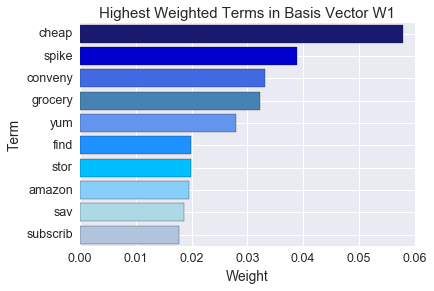

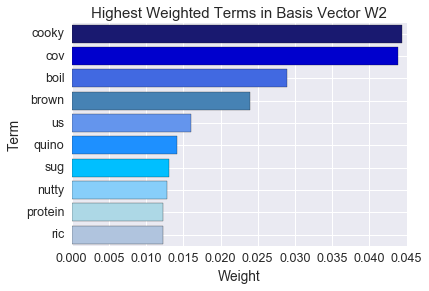

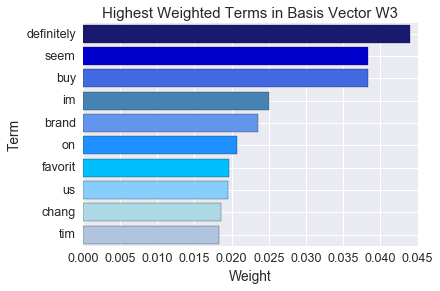

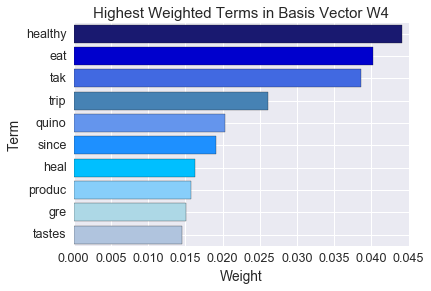

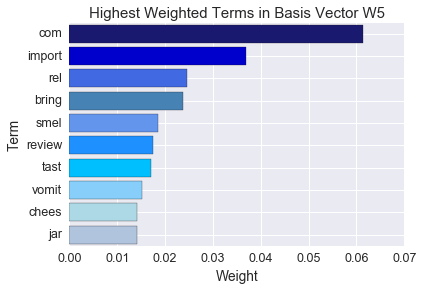

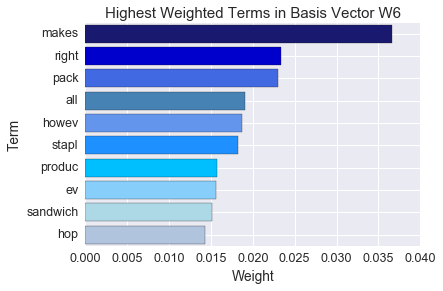

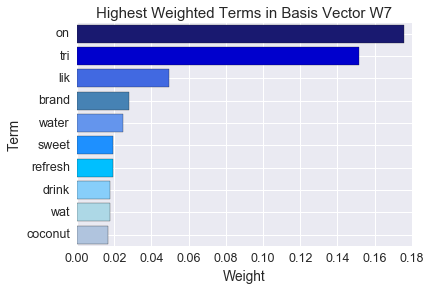

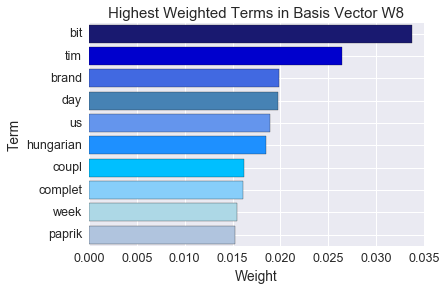

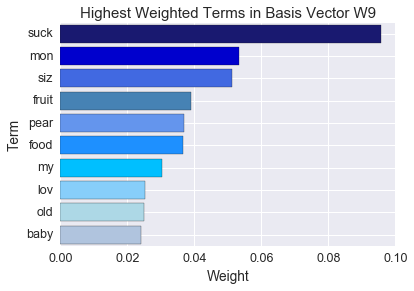

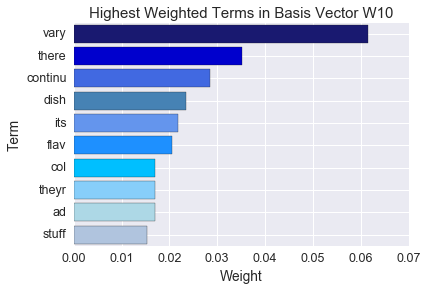

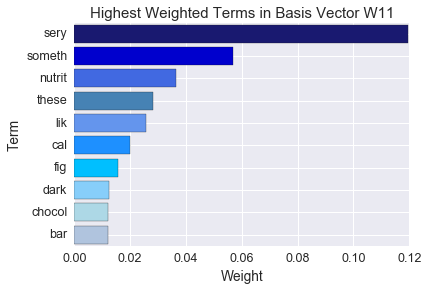

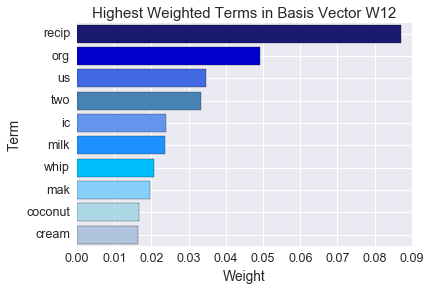

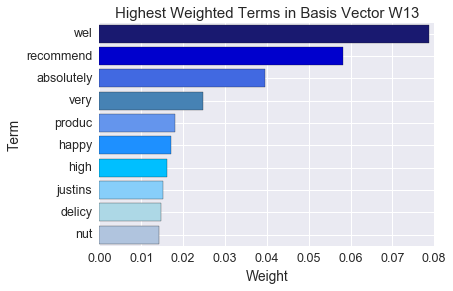

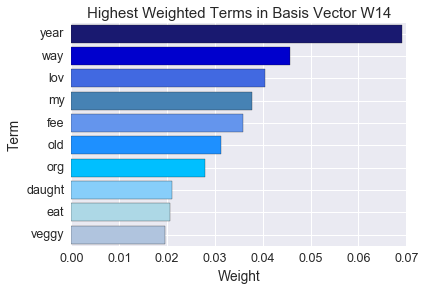

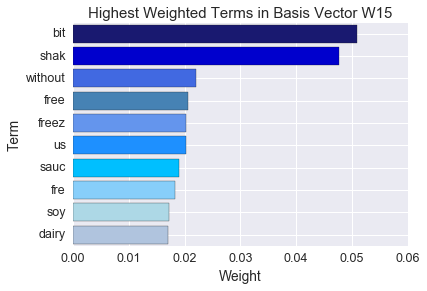

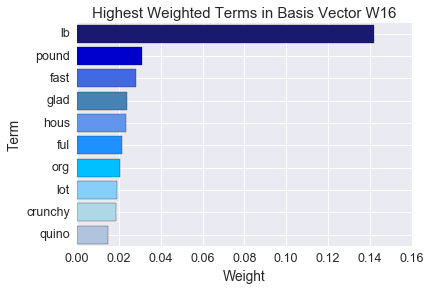

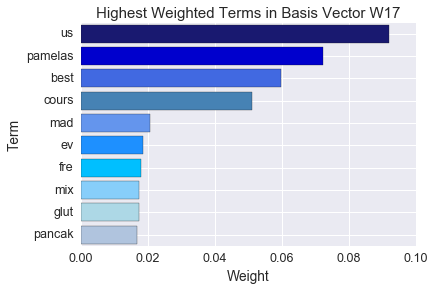

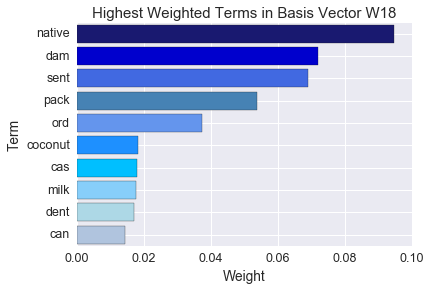

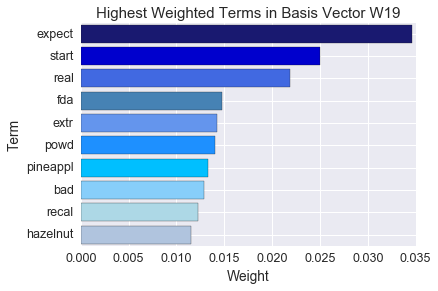

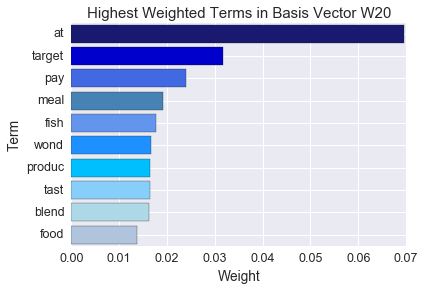

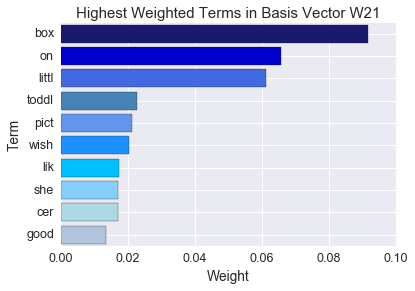

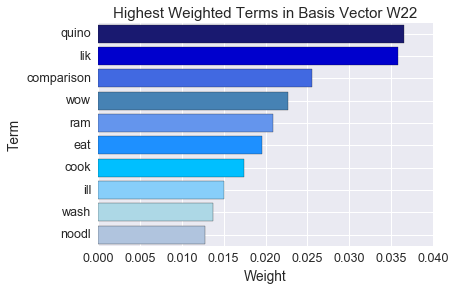

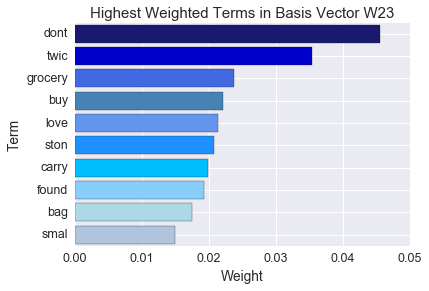

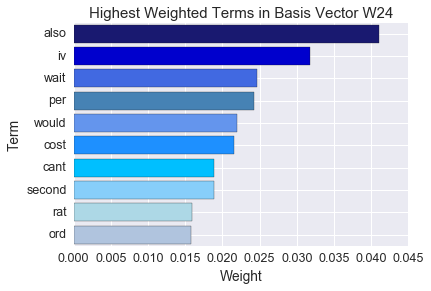

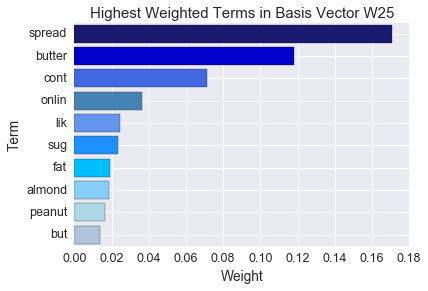

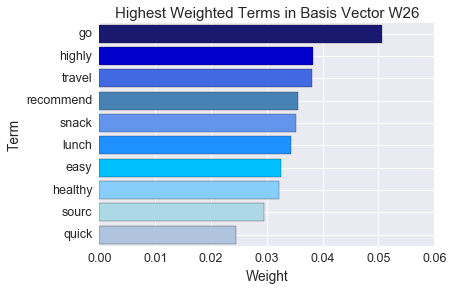

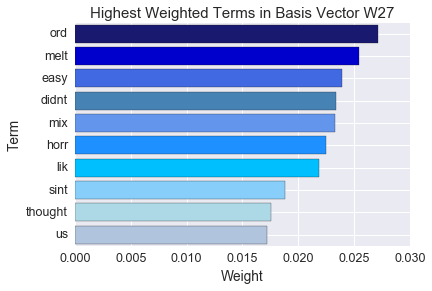

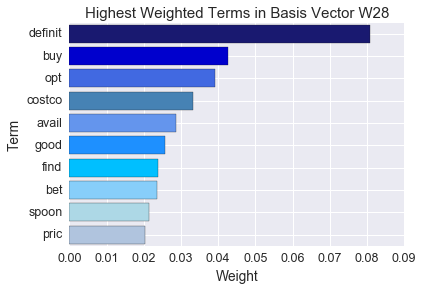

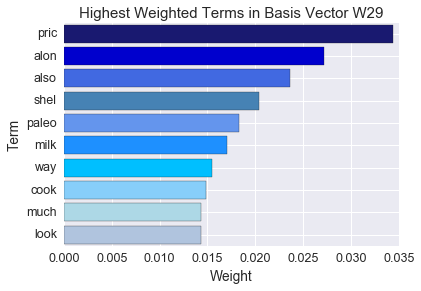

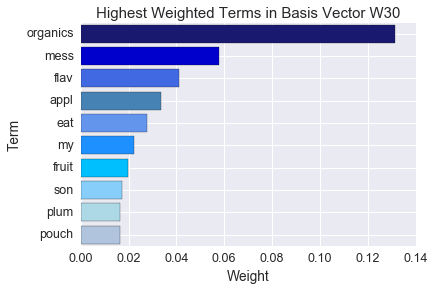

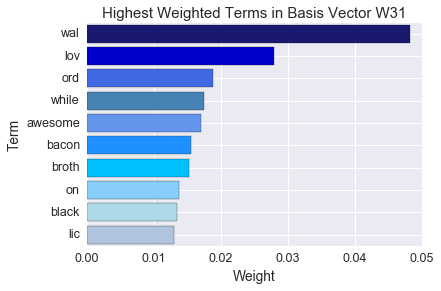

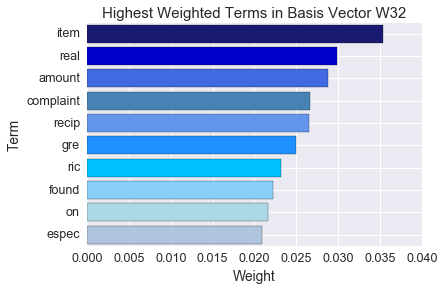

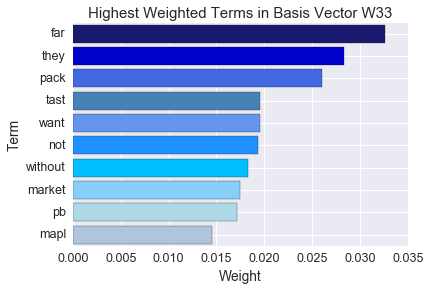

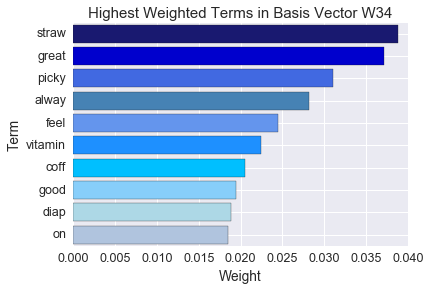

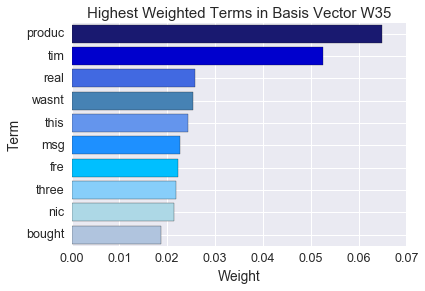

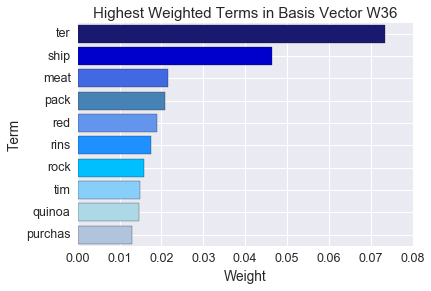

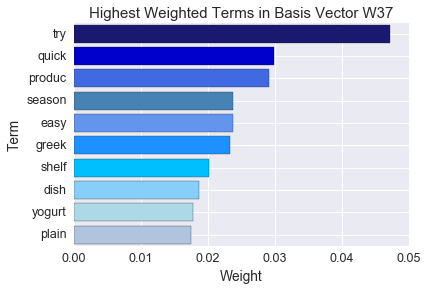

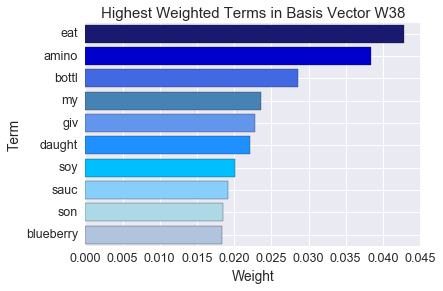

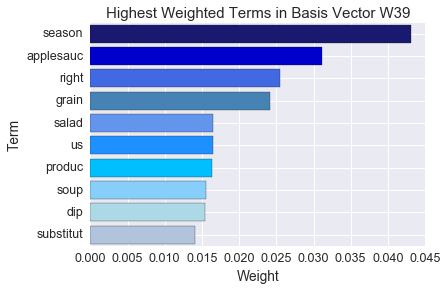

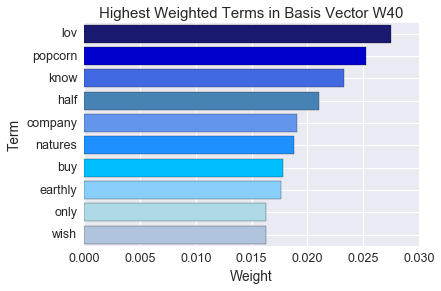

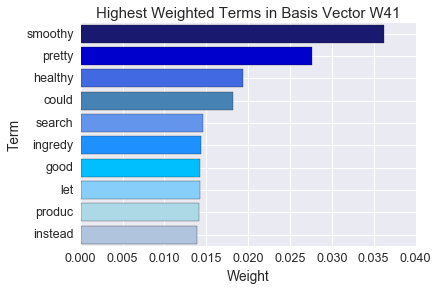

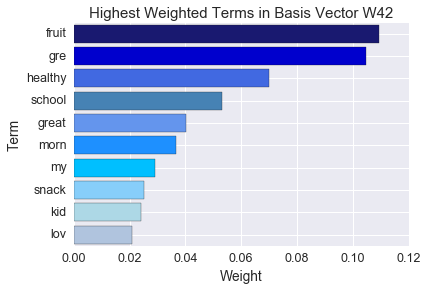

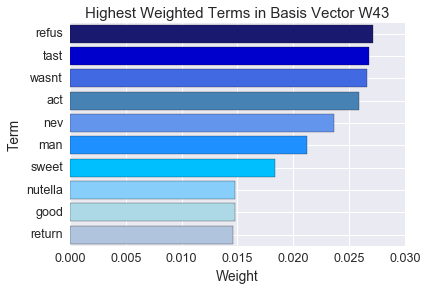

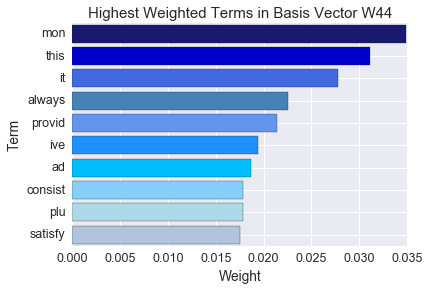

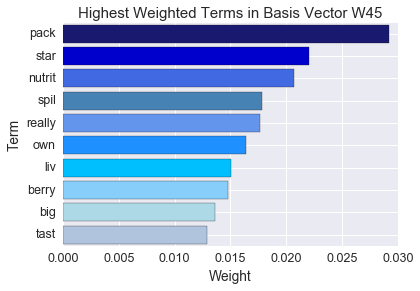

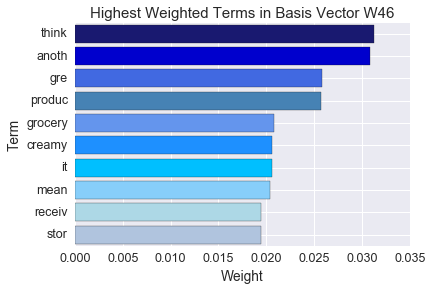

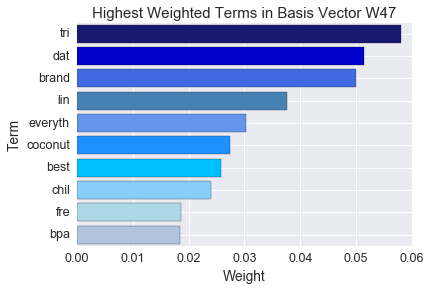

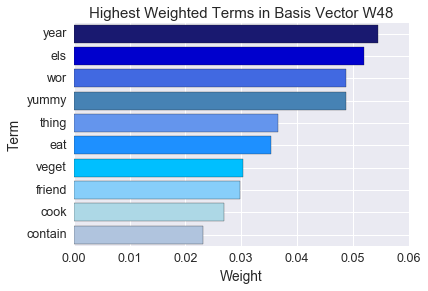

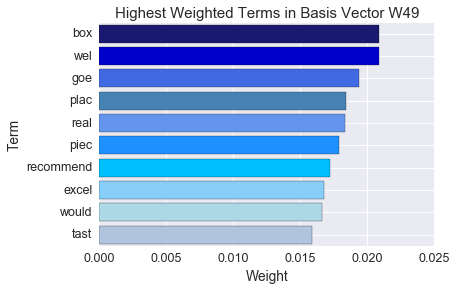

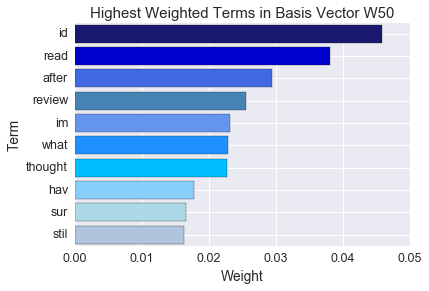

In [223]:
##Terms and Weights Recalled Review
import seaborn as sns
sns.set(style="darkgrid", color_codes=True, font_scale=1.25, palette='bright')

feature_names =  vectorizer.get_feature_names()
import matplotlib.pylab as plb
%matplotlib inline

def plot(W,termlist):
    for c in range(W.shape[1]):
        top10 = np.argsort(np.asarray(W[:,c].todense()).flatten())[-10:]
        val = W[top10, c].todense()
        plb.figure(c + 1)
        plb.barh(np.arange(10) + .5, val, color=['LightSteelBlue', 'LightBlue', 'LightSkyBlue', 'DeepSkyBlue', 'DodgerBlue', 
                                                 'CornflowerBlue','SteelBlue','RoyalBlue','MediumBlue', 'MidnightBlue'], align='center')
        plb.yticks(np.arange(10) + .5, [feature_names[i] for i in top10][::-1])
        plb.xlabel("Weight")
        plb.ylabel("Term")
        plb.title("Highest Weighted Terms in Basis Vector W%d" % (c + 1))
        plb.grid(True)
    
plot(fit_recall.basis(), feature_names)

It appears that some recall specific-topics emerge from the recalled products (code prints 50 topics total when it is run).  There are still many product-related topics, however.

/Applications/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


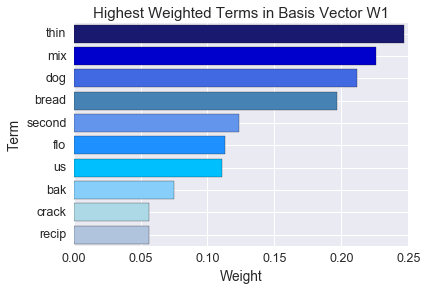

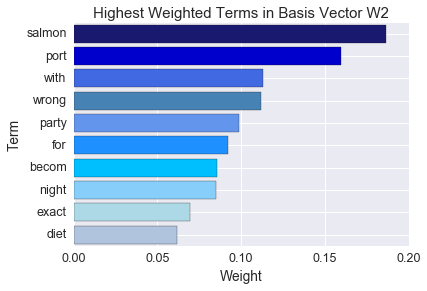

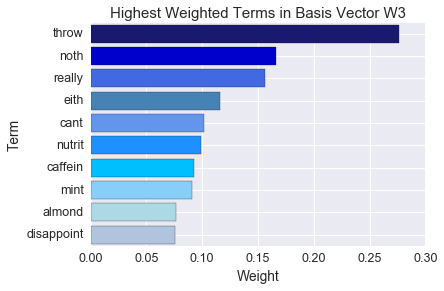

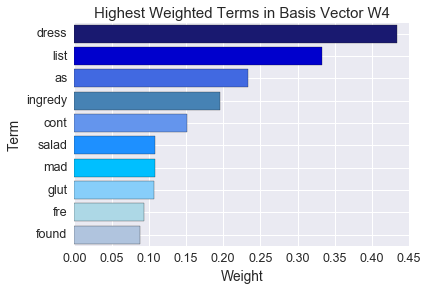

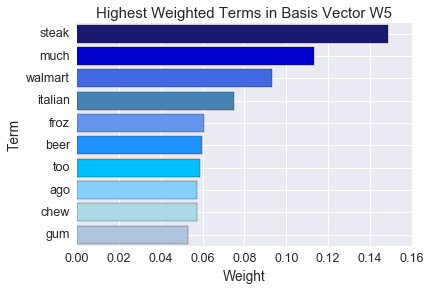

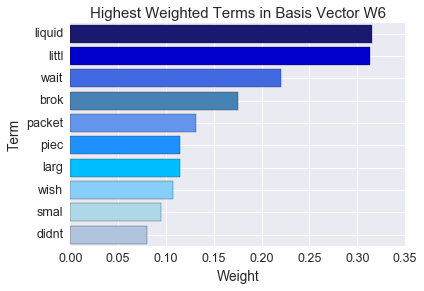

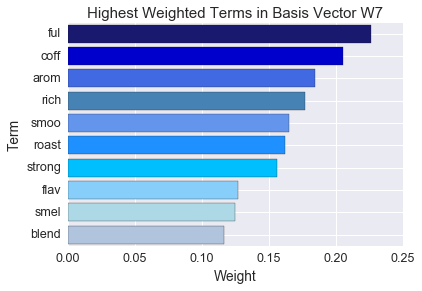

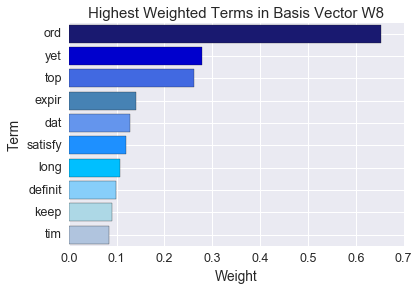

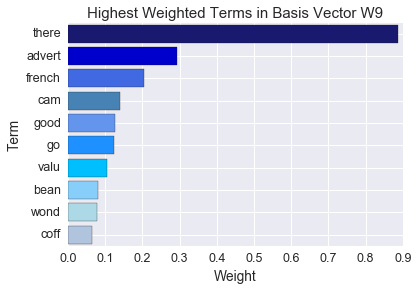

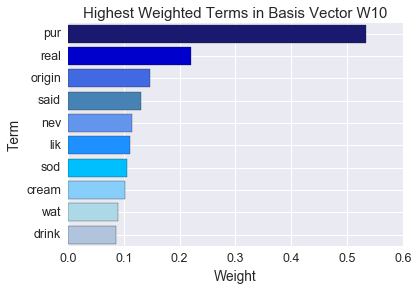

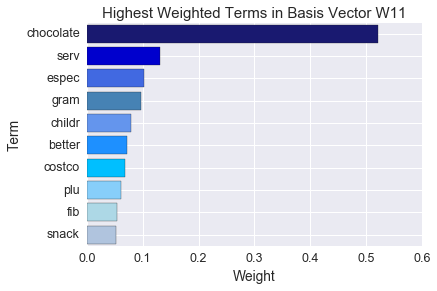

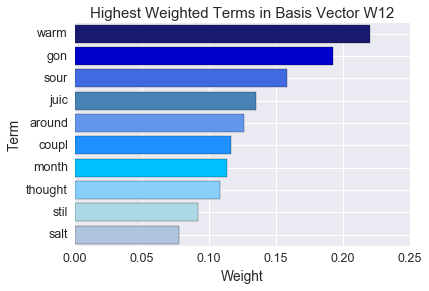

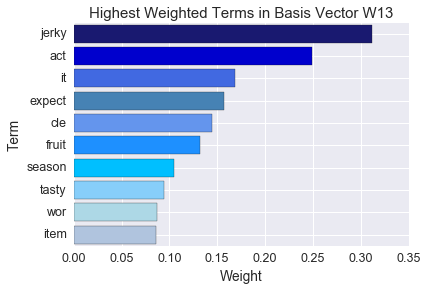

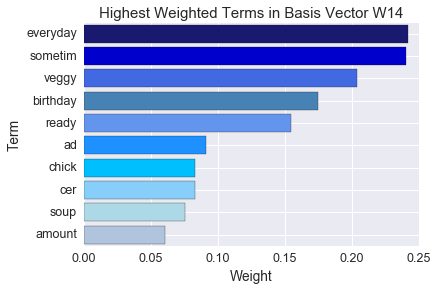

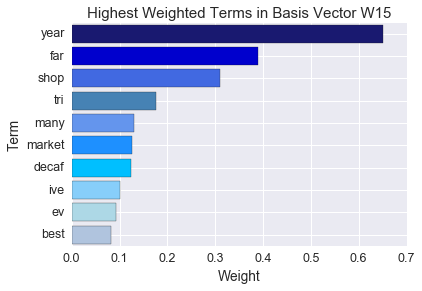

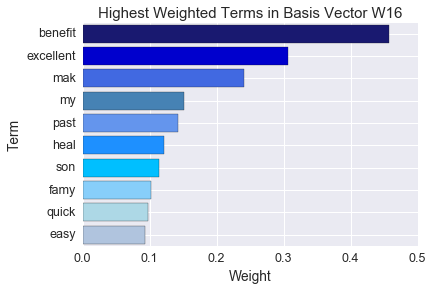

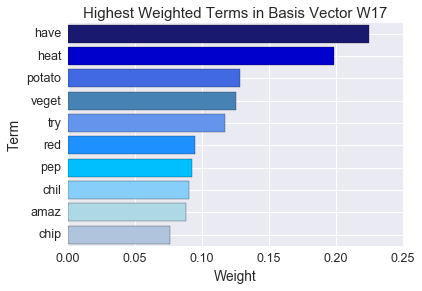

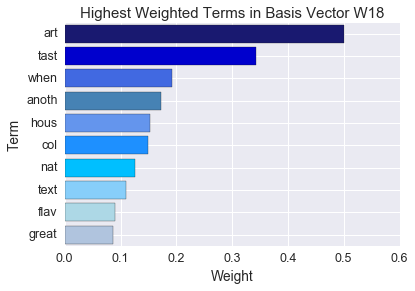

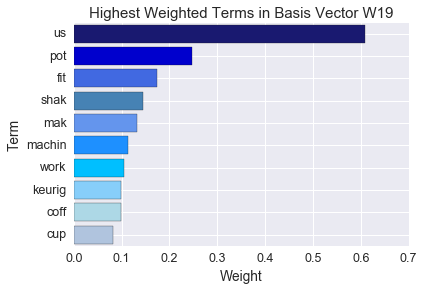

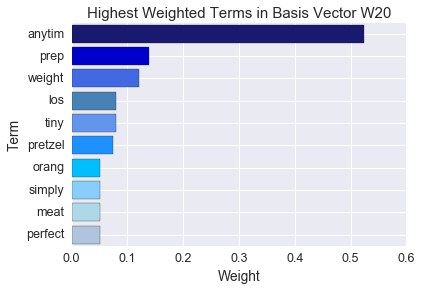

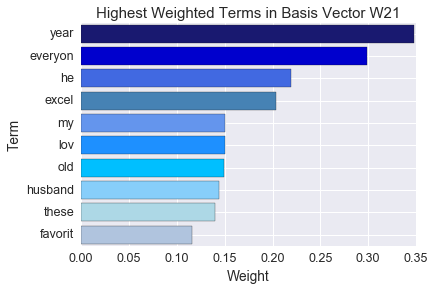

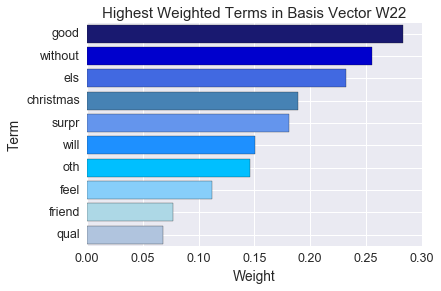

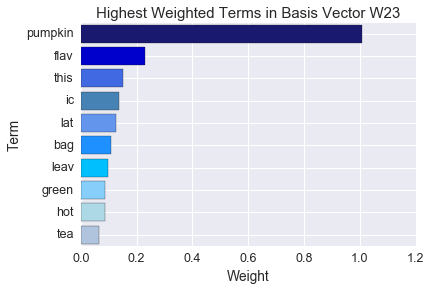

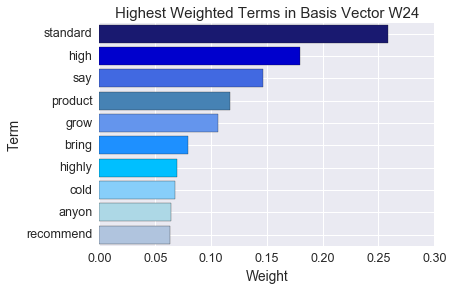

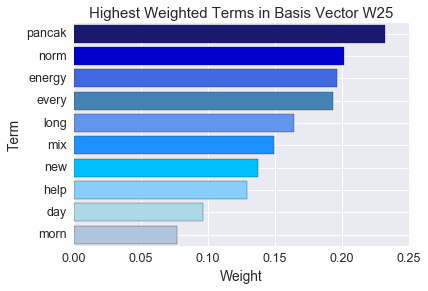

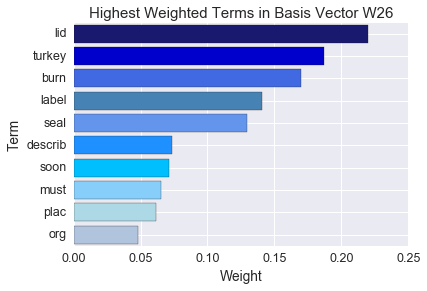

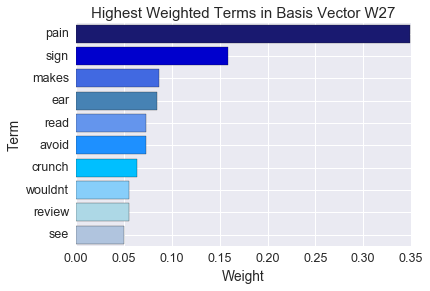

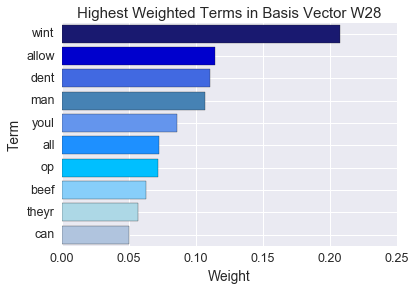

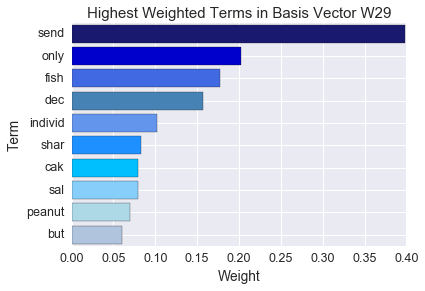

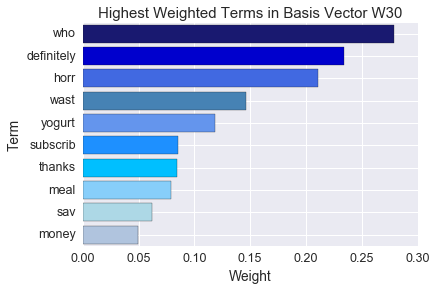

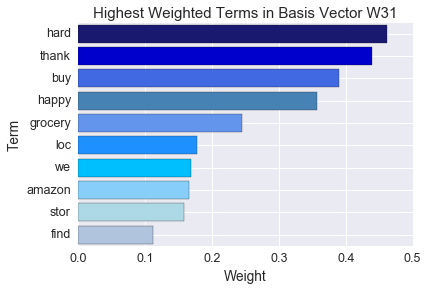

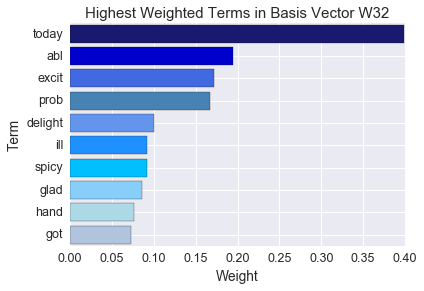

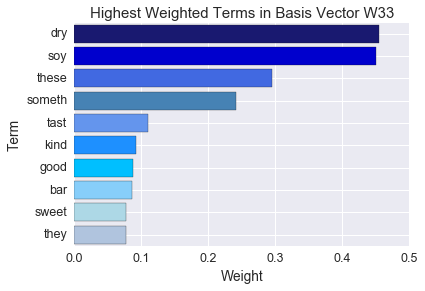

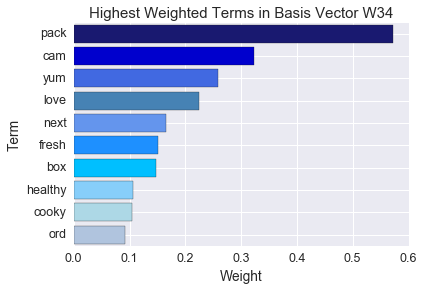

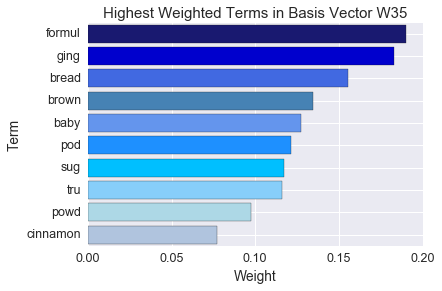

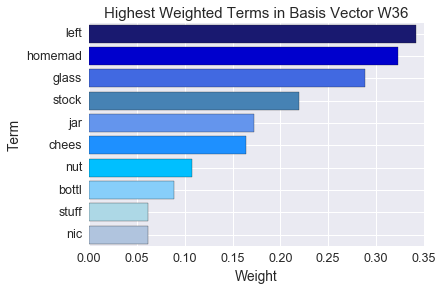

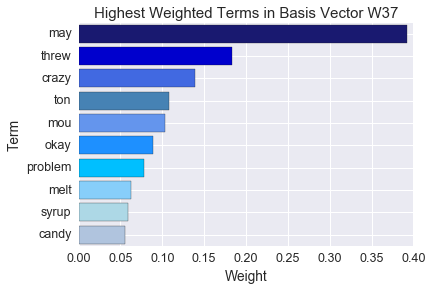

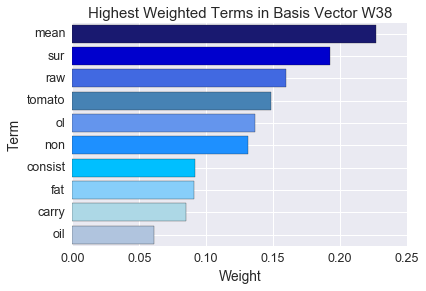

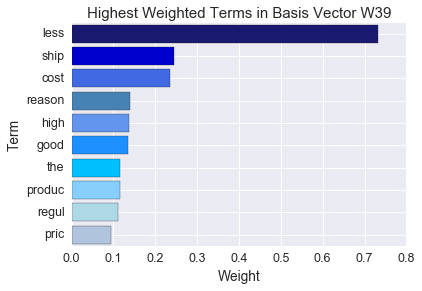

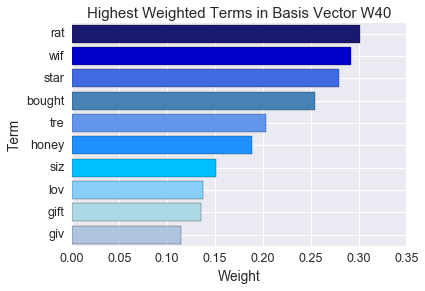

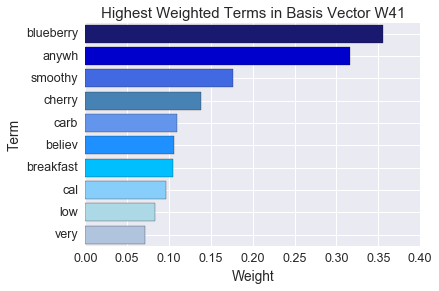

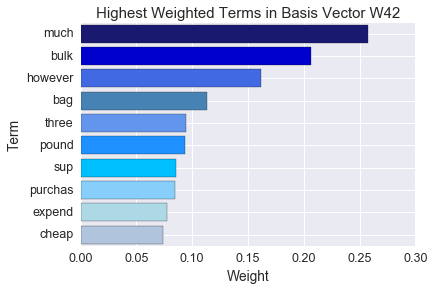

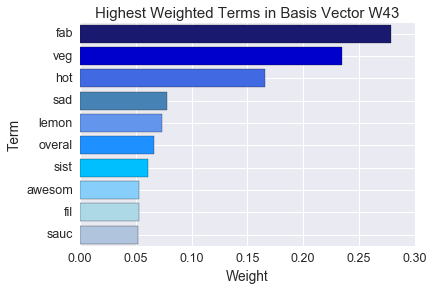

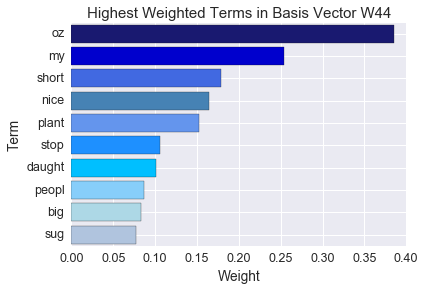

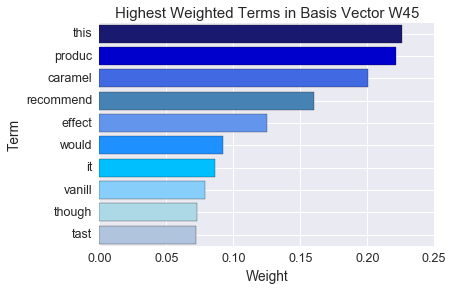

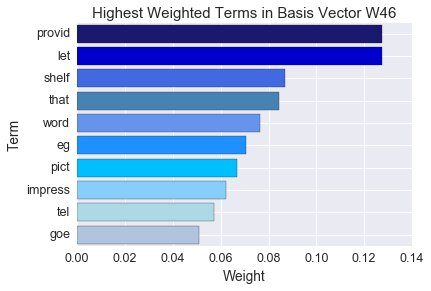

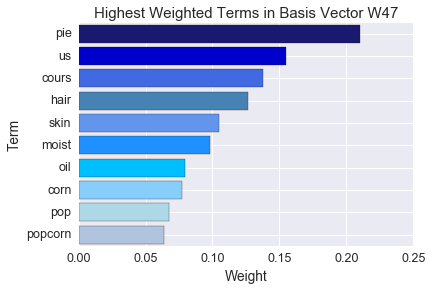

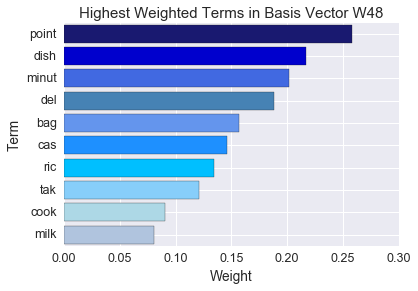

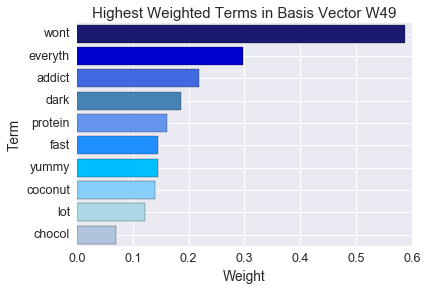

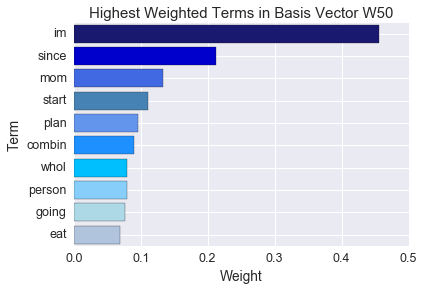

In [224]:
##Terms and Weights NonRecalled
plot(fit_nonrecall.basis(), feature_names)

## NMF with only 2 Star review or below

The code below runs topic modeling on only product reviews with 2-stars or lower.  The idea behind this process was to see if unsupervised dimensionality reduction could pull out recall-topics among products that were all 'bad' from the consumers point of view.  There was some success with this process!

In [227]:
##Make word count matrix with rating
text_vector2 = text_vector.drop('recalled_1y', axis=1)
score_df = pd.DataFrame(Subset.overall).reset_index(drop=True)
score_df.columns = ['Score']
text_vector2 = pd.concat([text_vector2, score_df], axis=1) 
text_vector2 = text_vector2[text_vector2.Score < 3]

In [229]:
##Transpose and Make sparse
text_vector2 = text_vector2.drop('Score', axis=1)
text_vector2 = text_vector2.transpose()
text_vector_sparse2 = scipy.sparse.csr_matrix(text_vector2)

In [230]:
## Non-negative matrix factorization
nmf = nimfa.Nmf(text_vector_sparse2, rank=50, seed='random_c', update="divergence", objective="div")
fit = nmf()

/Applications/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


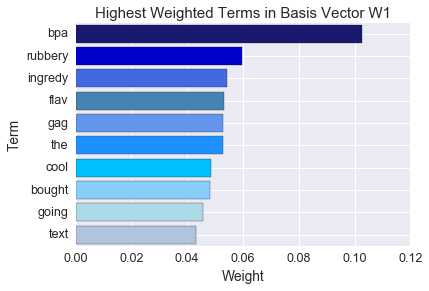

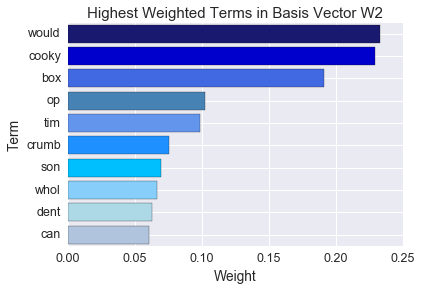

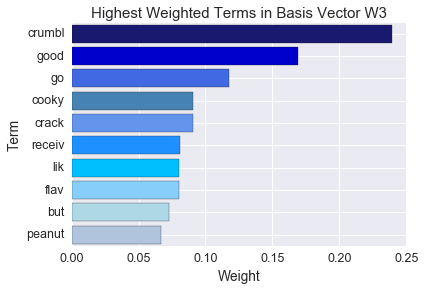

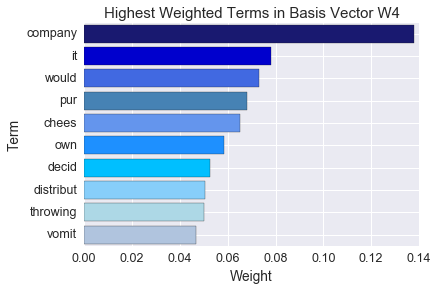

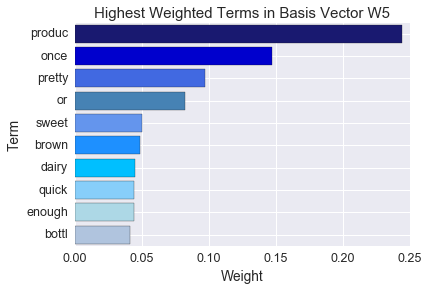

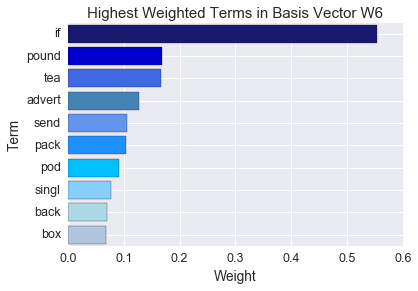

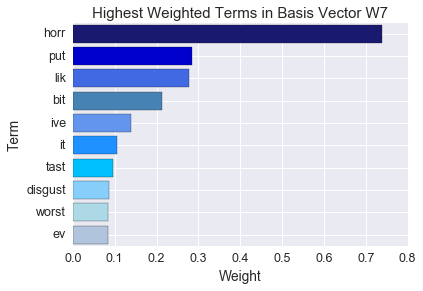

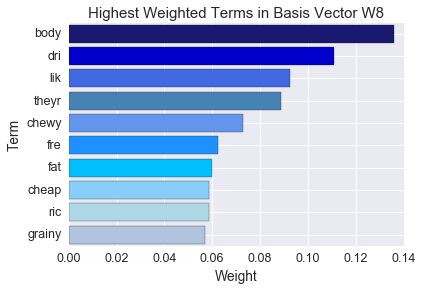

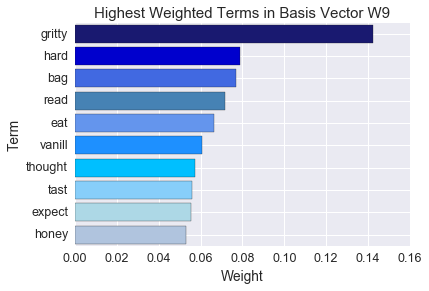

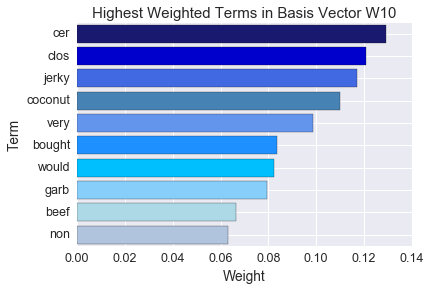

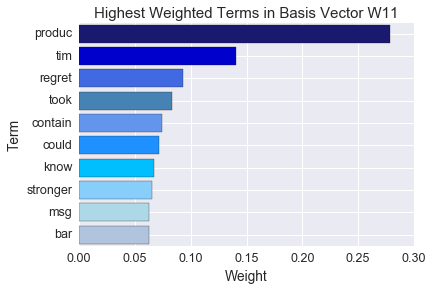

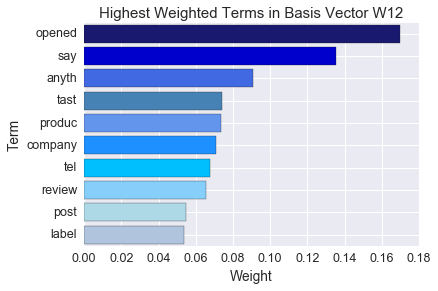

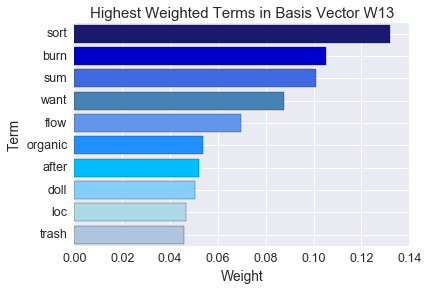

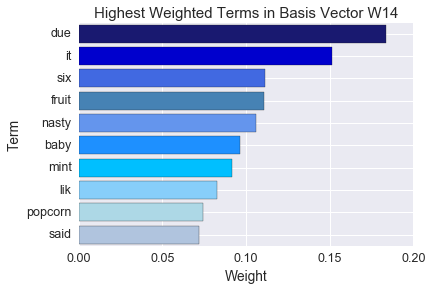

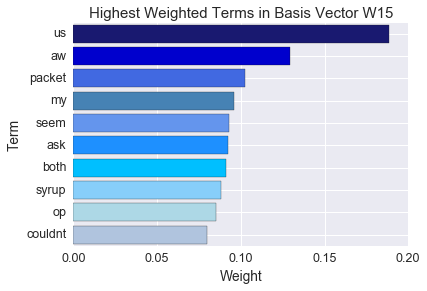

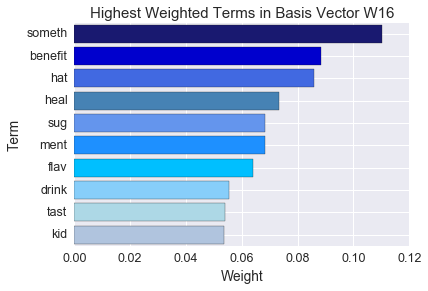

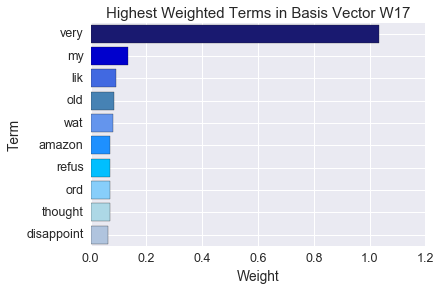

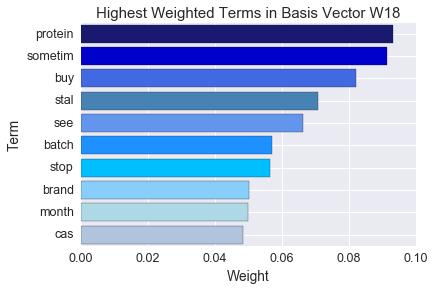

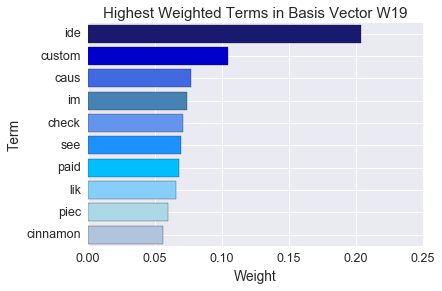

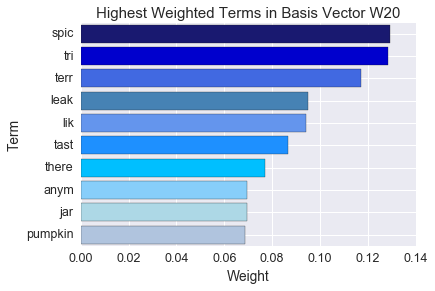

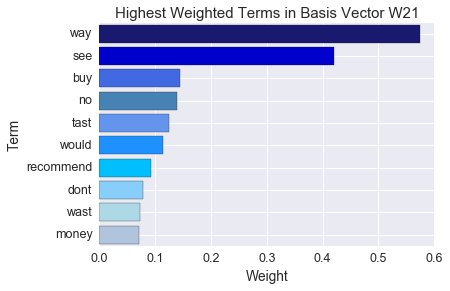

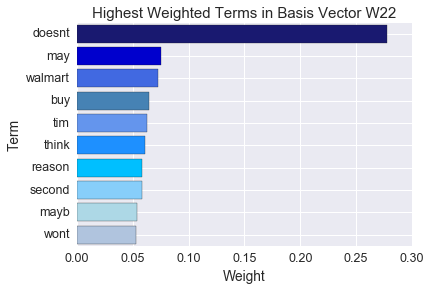

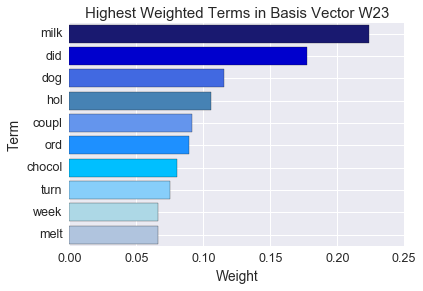

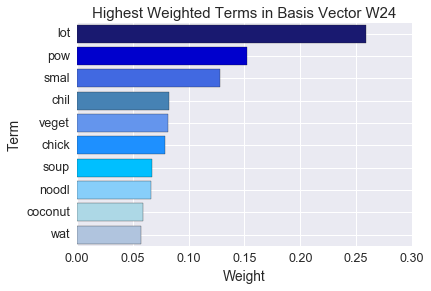

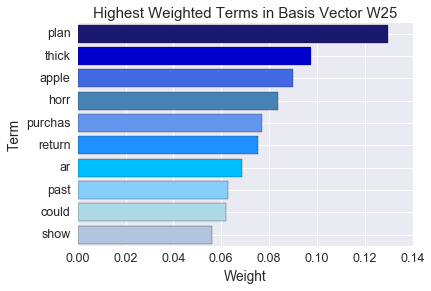

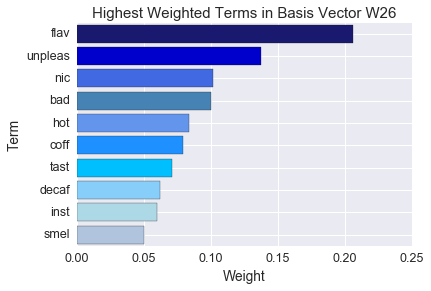

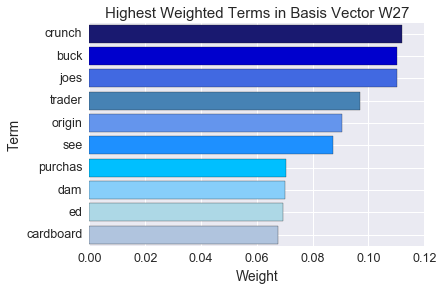

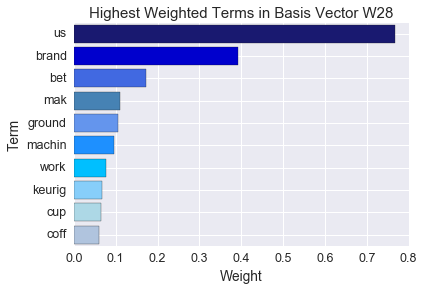

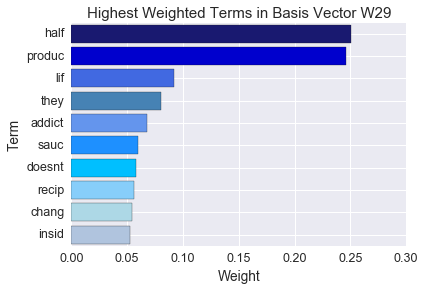

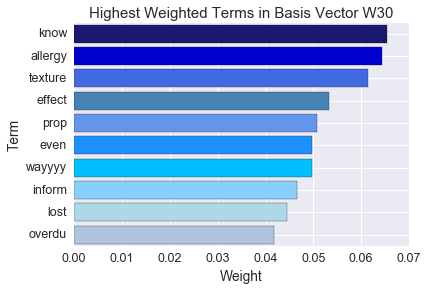

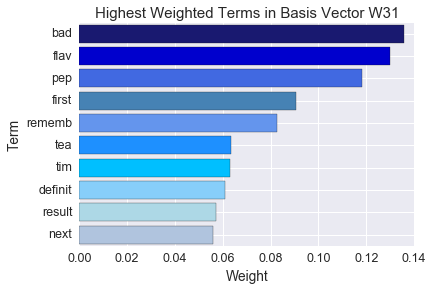

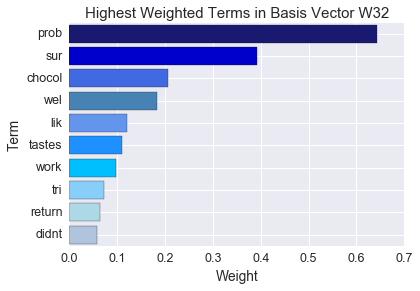

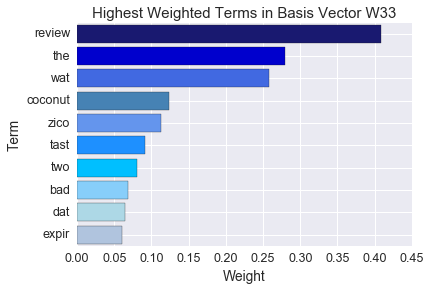

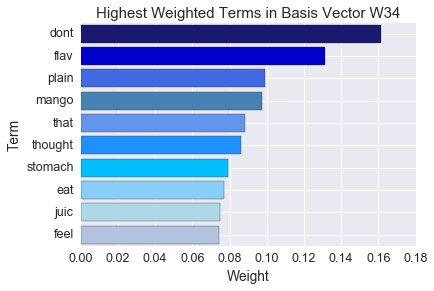

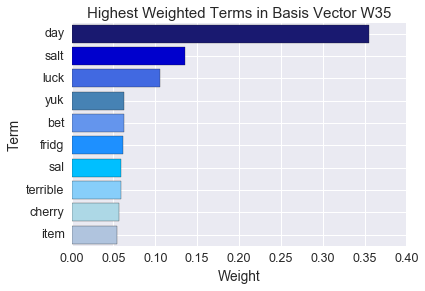

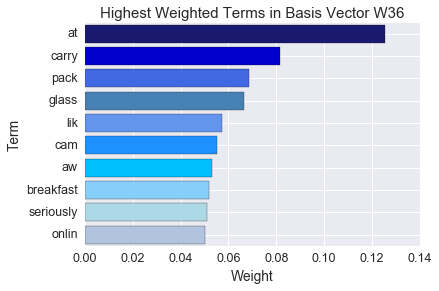

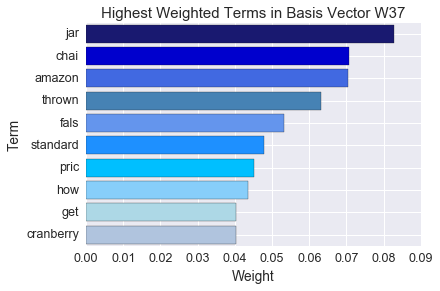

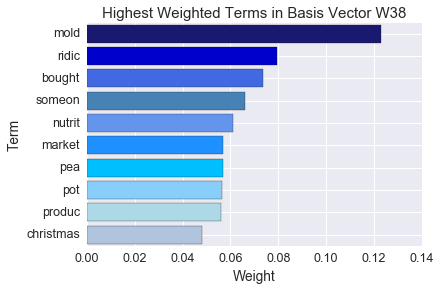

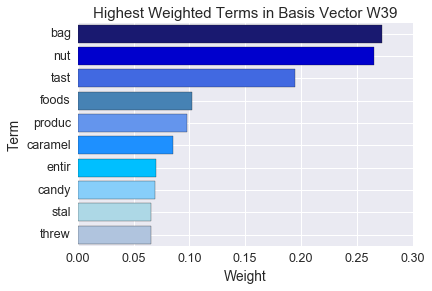

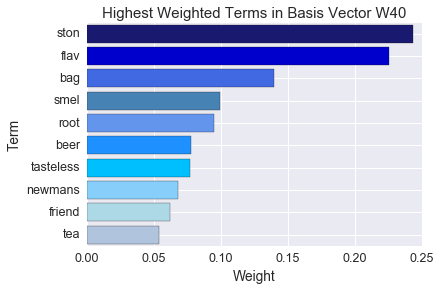

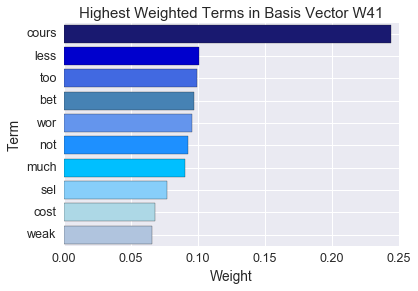

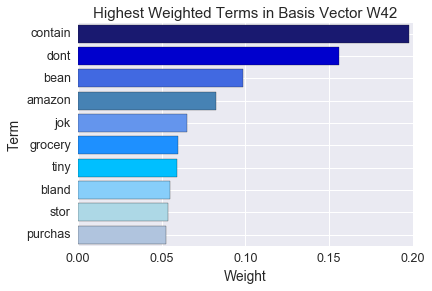

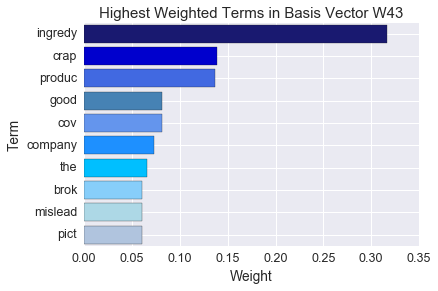

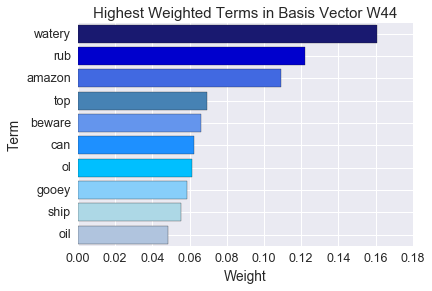

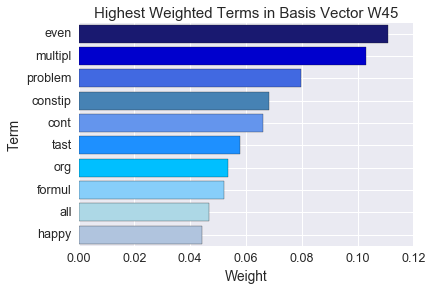

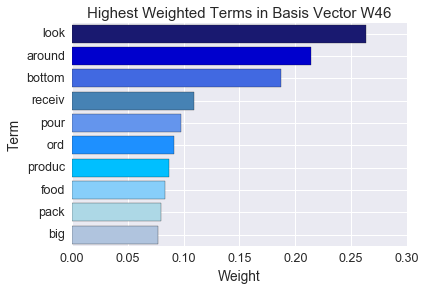

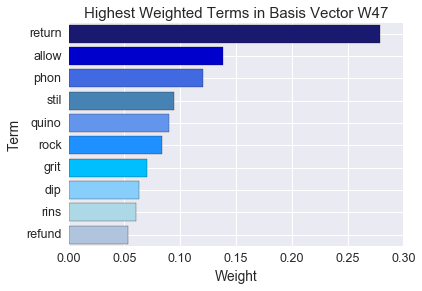

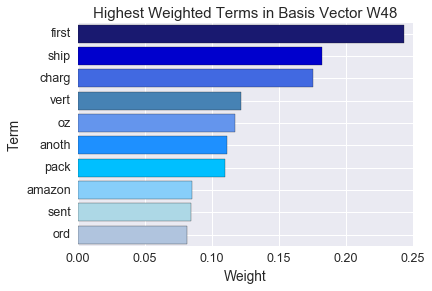

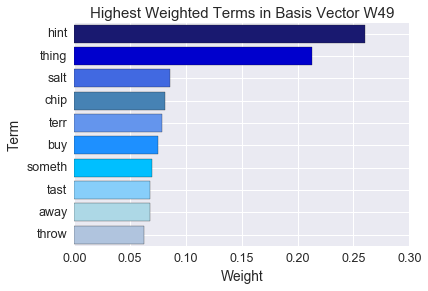

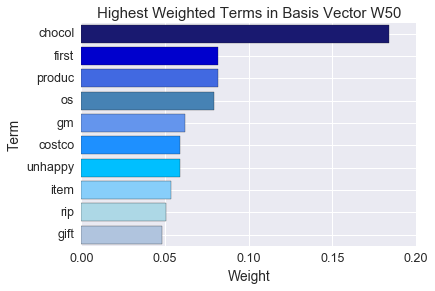

In [234]:
##Terms and Weights
plot(fit.basis(), feature_names)

## NMF without product category words

The code below brings in the text from all categories in the Amazon review dataset, and removes these words from the review text.  NMF is run on the resulting corpus, in order to see if removing category text helps to 'control' for product-specific topics.  This approach had limited success, and a next step would be to apply NMF to each category type, and see if recall-specific topics emerge.

In [235]:
##Call in data that includes ASINs from original press release data
recall_data = pandas.read_csv(os.path.join(wd,"..","data/processed/asin_intersection_full.csv"),
                              encoding='ISO-8859-1')

## Define category words to be removed
category_terms = recall_data.categories.str.replace('[^a-zA-Z\s]',' ')
category_terms = category_terms.str.cat()
category_terms = word_tokenize(category_terms)

stemmed_category_terms = []
for word in category_terms:
    stem = st.stem(word)
    stemmed_category_terms.append(stem)

In [237]:
vectorizer_noncategory = CountVectorizer(binary=False, ngram_range=(1, 1), stop_words = stemmed_category_terms) ##Removed stopwords before stemming so don't apply here
text_vector_noncategory = vectorizer_noncategory.fit_transform(final_text)
text_vector_noncategory = transformer.fit_transform(text_vector_noncategory)
text_vector_noncategory_sparse = scipy.sparse.csr_matrix(text_vector_noncategory)

In [238]:
## Non-negative matrix factorization
nmf = nimfa.Nmf(text_vector_noncategory_sparse, rank=50, seed='random_c', update="divergence", objective="div")
fit_noncategory = nmf()

/Applications/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


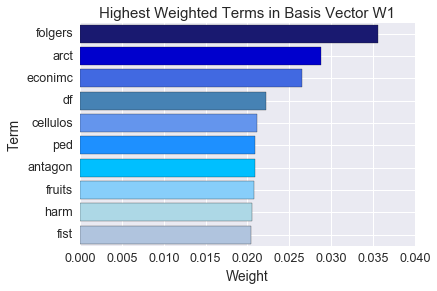

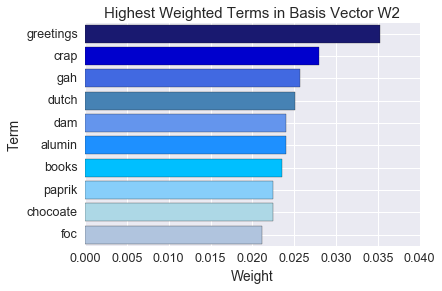

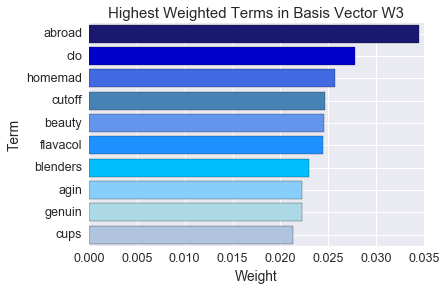

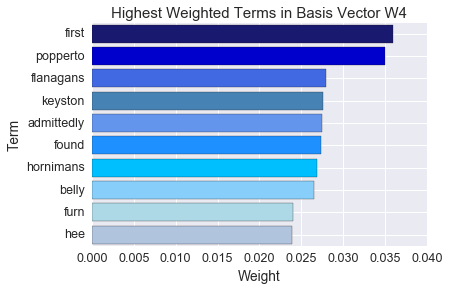

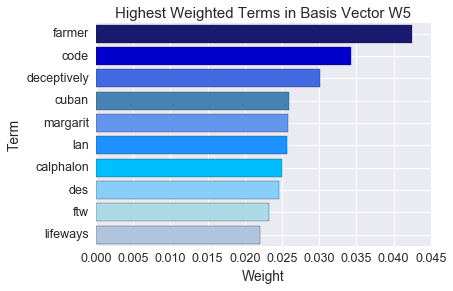

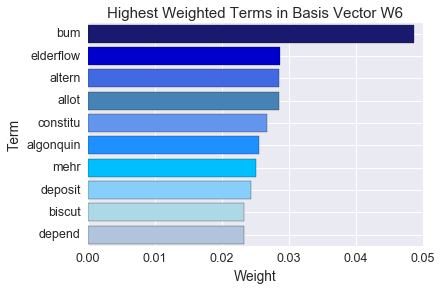

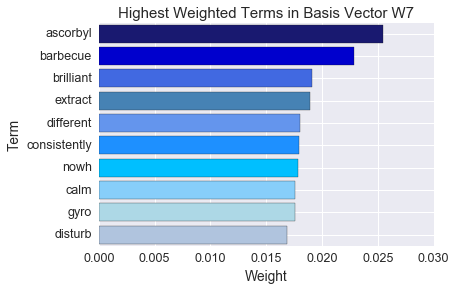

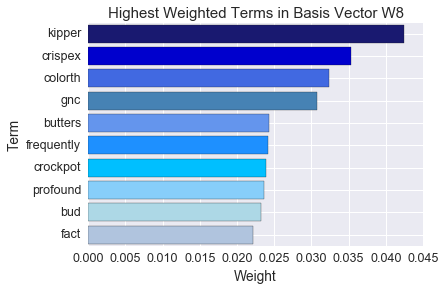

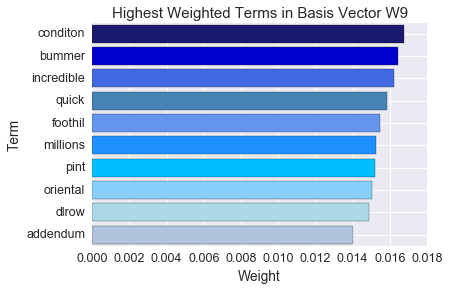

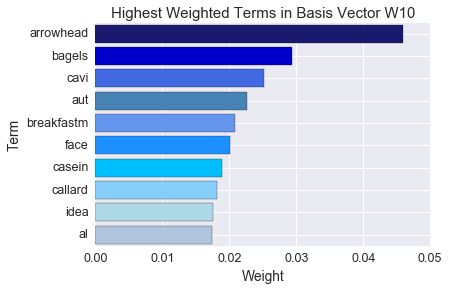

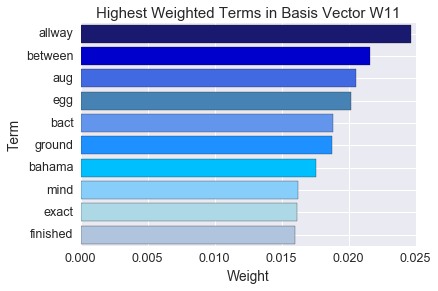

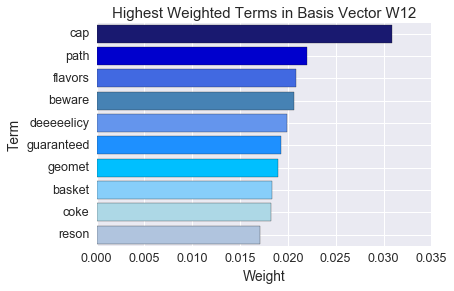

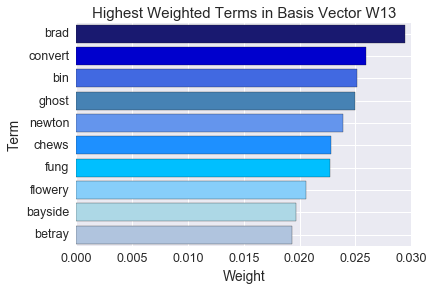

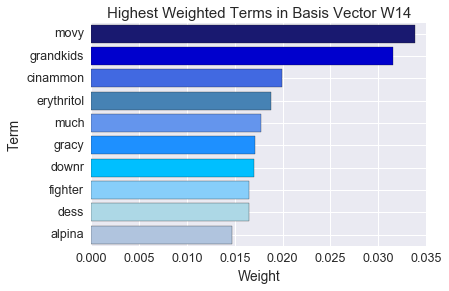

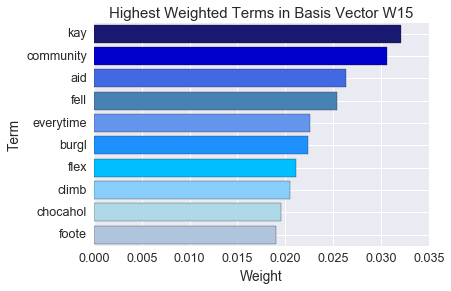

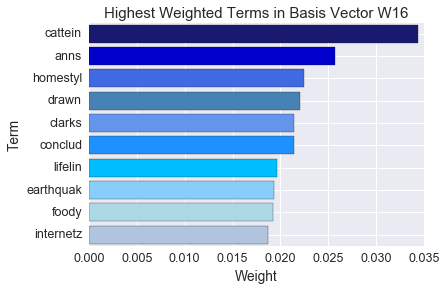

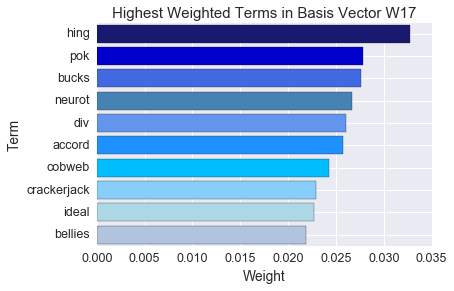

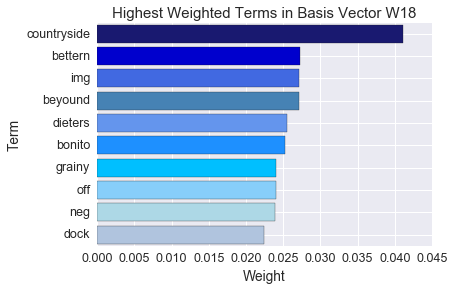

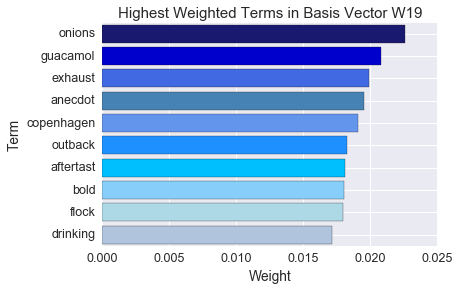

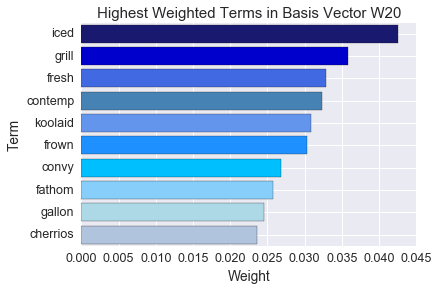

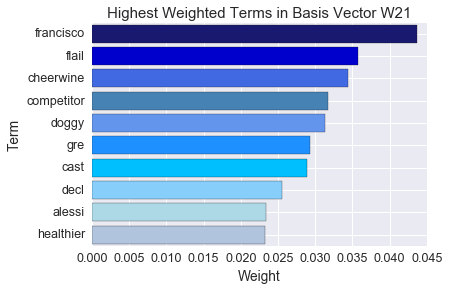

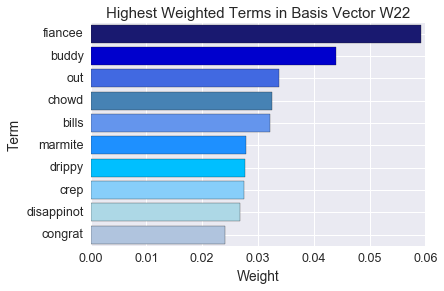

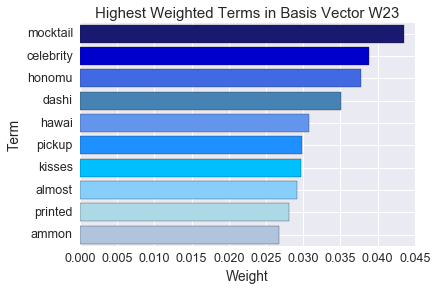

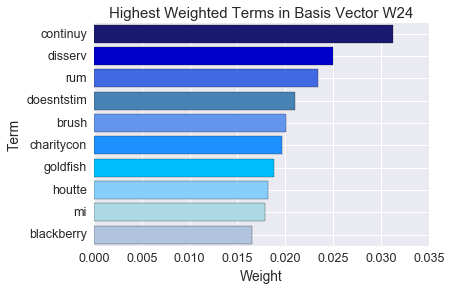

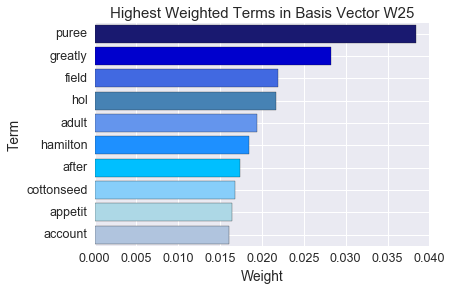

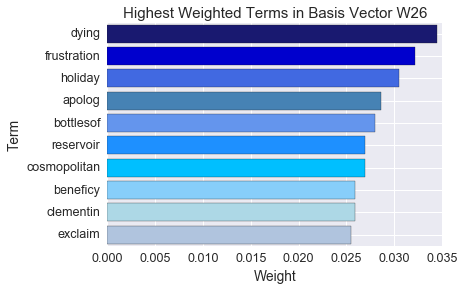

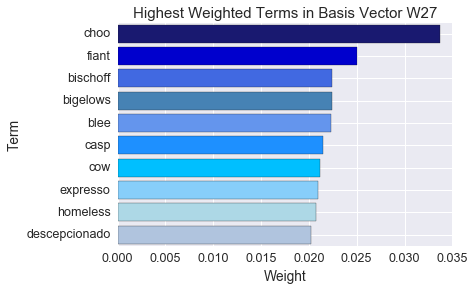

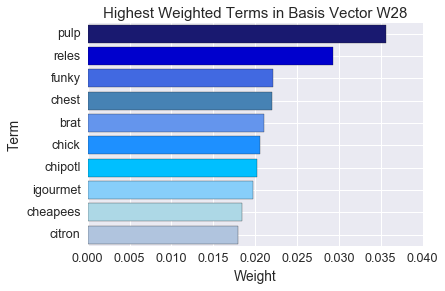

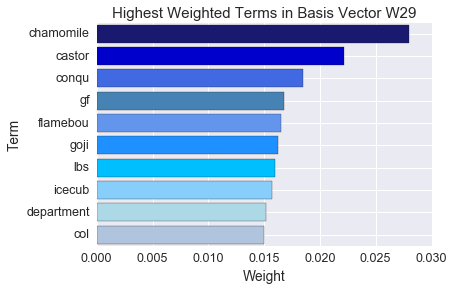

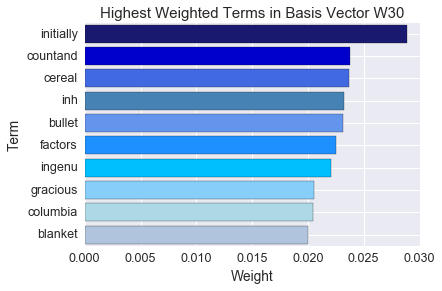

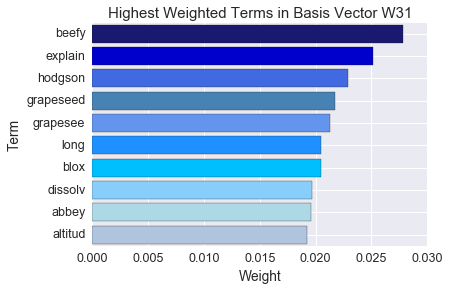

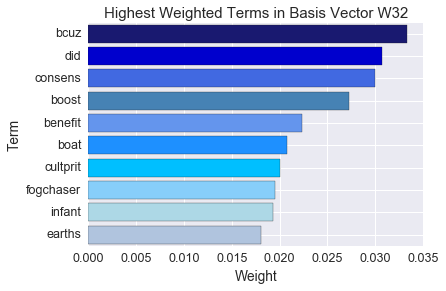

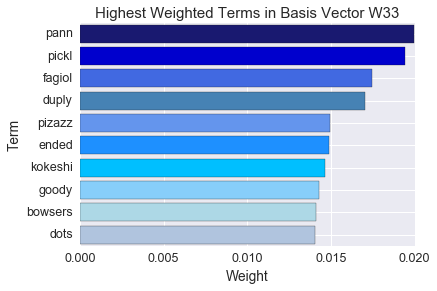

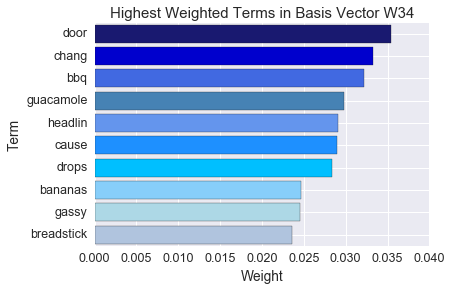

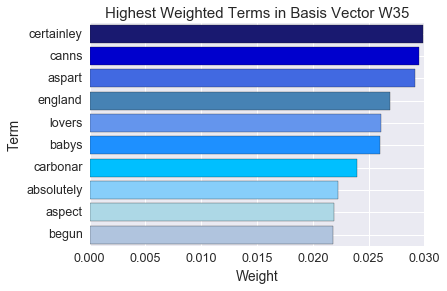

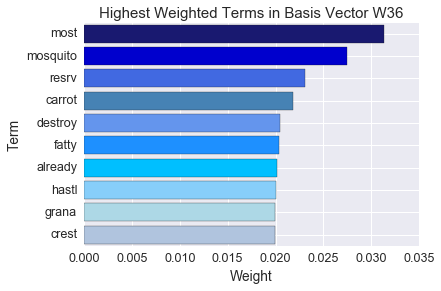

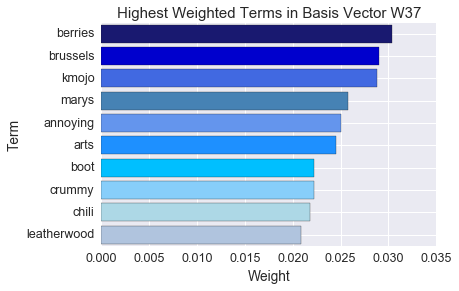

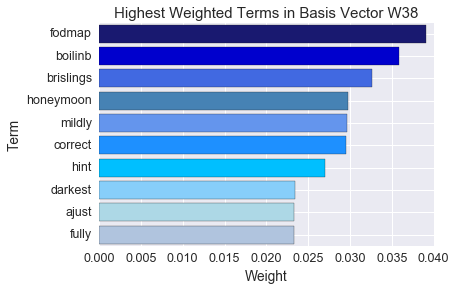

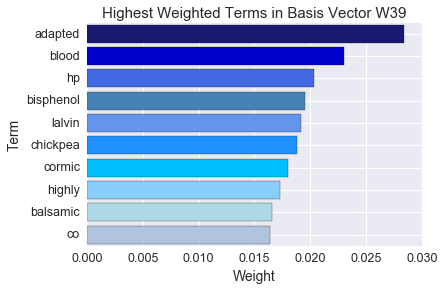

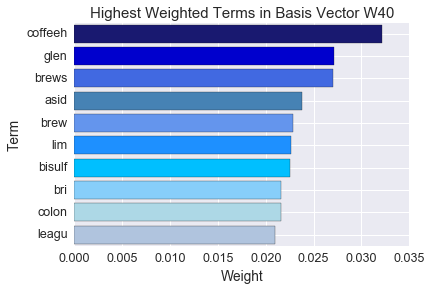

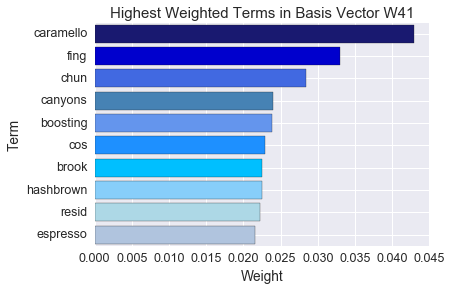

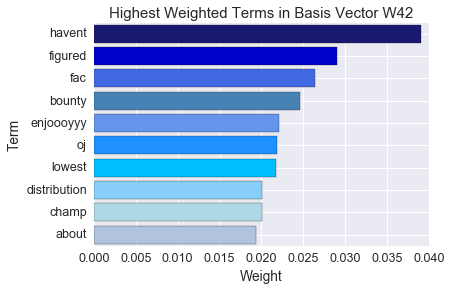

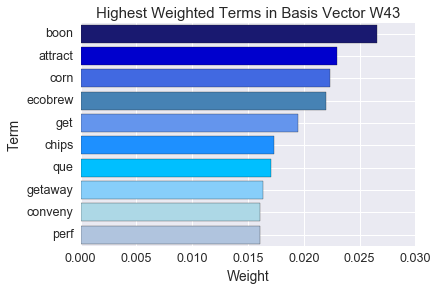

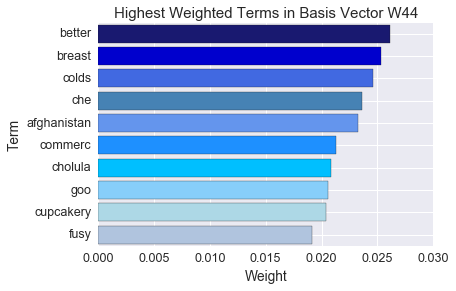

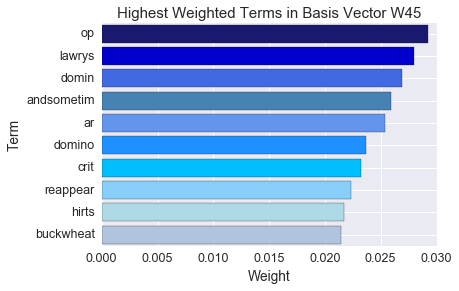

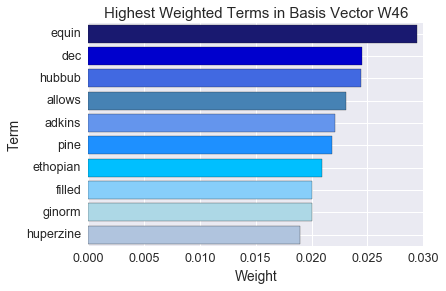

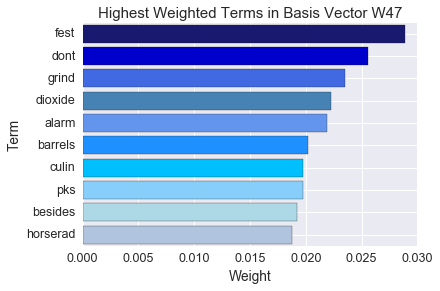

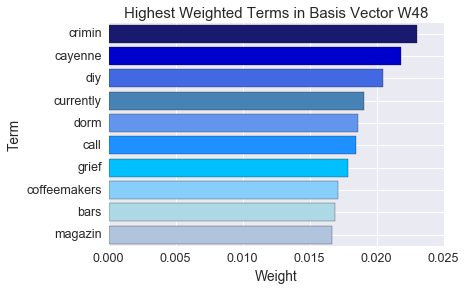

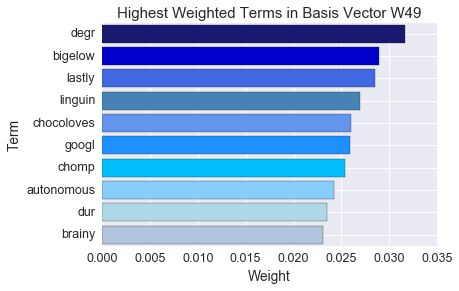

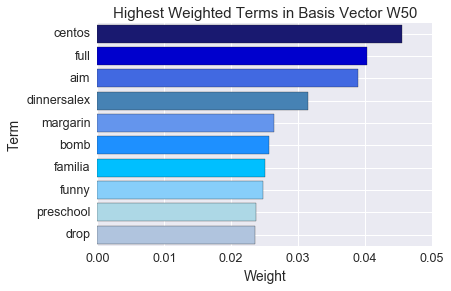

In [239]:
feature_names = vectorizer_noncategory.get_feature_names()
plot(fit_noncategory.basis(), feature_names)